## Executing randomized measurement on IBM quantum computers

This tutorial illustrates how to acquire and save randomized measurements on a quantum computer using Qiskit (RandomizedMeasurementsQiskit.ipynb). This data can be then postprocessed using our julia library RandomMeas (RandomizedMeasurementsQiskitPostprocessing.ipynb)

### Parameters

We consider here only four qubits, and will generate randomized measurements for the purpose of measuring state purities

In [2]:
import numpy as np
from numpy import random
#from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

#service = QiskitRuntimeService(name="ibm_quantum") #loading qiskit runtime service from a saved IBM account

N = 4 #number of qubits
NU = 2048 #Number of random unitaries
NM = 1024 # number of shots

### Selection of the quantum computer

In [3]:
### First Option: Custom parametrized local simulator
from qiskit_aer import AerSimulator
from qiskit_aer import noise
noise_model = noise.NoiseModel()
for i in range(N):
    p = 0.04*random.rand()
    print(" Qubit ", i, " has readout error ",p)
    read_err = noise.errors.readout_error.ReadoutError([[1-p, p],[p,1-p]])
    noise_model.add_readout_error(read_err,[i])
backend = AerSimulator(noise_model=noise_model)

### Second Option: Parametrized local simulator mimicking a quantum computer
#from qiskit_ibm_runtime.fake_provider import FakeBrisbane
#backend = FakeBrisbane()

### Third Option: A quantum computer
# print("Available backends: ",service.backends())
#service = QiskitRuntimeService(name="ibm_cloud") #loading qiskit runtime service from a saved IBM account
#backend = service.least_busy(operational=True, simulator=False, min_num_qubits=12)
#backend = service.backend("ibm_brisbane")


print("Chosen backend: ",backend)
sampler = Sampler(mode=backend)
sampler.options.default_shots = NM
sampler.options.max_execution_time = 60 #max execution time (sufficient for Nu=64,cost:~50 $)

 Qubit  0  has readout error  0.013376900552835315
 Qubit  1  has readout error  0.02218260237858992
 Qubit  2  has readout error  0.018524987754470233
 Qubit  3  has readout error  0.020171300246316266
Chosen backend:  AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure']>)


### Parametrization of the quantum circuit

We prepare a cluster states on the four qubits, and include the random unitaries in the definition of the quantum circuit, as parametrized rotations.

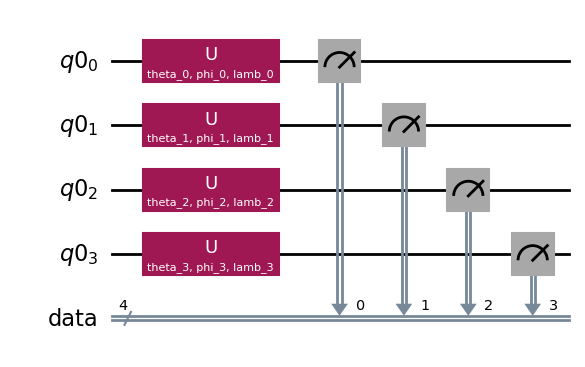

In [4]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister

qreg = QuantumRegister(N)
creg_data = ClassicalRegister(N, name="data")

#Preparation of a $N$-qubit unidimensional cluster state
qc_state = QuantumCircuit(qreg,creg_data)
for i in range(N):
    qc_state.h(i)
for i in range(0,N-1,2):
    qc_state.cz(i,i+1)
for i in range(1,N-1,2):
    qc_state.cz(i,i+1)

# randomized measurements parametrized by Euler Angles via the "u" gate
qc_meas = QuantumCircuit(qreg,creg_data)#,creg_check)
phi,theta,lamb = [],[],[]
for i in range(N):
    phi.append(Parameter("phi_{:d}".format(i)))
    theta.append(Parameter("theta_{:d}".format(i)))
    lamb.append(Parameter("lamb_{:d}".format(i)))
    qc_meas.u(theta[i], phi[i], lamb[i],i)
qc_meas.measure(qreg,creg_data)

qc = qc_state.compose(qc_meas)
qc_meas.draw('mpl')

### Generation of the Random angles

We use here standard Qiskit code to represent random unitaries as Euler angles parametrizing our circuits

In [5]:
from qiskit.quantum_info import random_unitary, Operator
from qiskit.synthesis import OneQubitEulerDecomposer

decomposer = OneQubitEulerDecomposer(basis='U')
u = 1j*np.zeros((NU,N,2,2))

isa_qcs = []
params = {}
for i in range(N):
    theta_ = np.zeros(NU)
    phi_ = np.zeros(NU)
    lamb_ = np.zeros(NU)
    for r in range(NU):
        u[r,i,:,:] = random_unitary(2)
        op = Operator(u[r,i,:,:])
        theta_[r],phi_[r],lamb_[r]  = decomposer.angles(op)
    params = params | { theta[i]:theta_,phi[i]: phi_, lamb[i]:lamb_ }

### Sending the job on IBM's hardware

First we transpile the quantum circuit qc, as well as the measurement circuit qc_meas (whose results will be used as calibrated data for building robust classical shadows, cf dedicated jupyter notebook for detailed explanations)

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_qc_meas = pm.run(qc_meas)
isa_qc = pm.run(qc)

In [7]:
job = sampler.run([(isa_qc_meas,params),(isa_qc,params)])
print(job.job_id(), job.status())

1f502b5b-496c-4b68-b3dd-e35780bbdf8a JobStatus.RUNNING


### Saving data
Finally we convert the data structure used by qiskit to a numpy array that we will be able to load in julia later using the library NPZ

In [11]:
#job = service.job('') #uncomment if you want to retrieve a given job using its ID
result = job.result()
np.save("data/"+job.job_id()+"_u",u)
data = np.zeros((2,NU,NM,N),dtype=int)
for r in range(NU):
    for j in range(2):
        counts = result[j].data["data"][r].get_bitstrings()
        for m in range(NM):
            data[j,r,m,:] = np.array([int(counts[m][N-1-i]) for i in range(N)])
np.save("data/"+job.job_id()+"_data",np.int64(data))

In [12]:
job.job_id()

'1f502b5b-496c-4b68-b3dd-e35780bbdf8a'